In [25]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, Dataset
import torch
from torcheval.metrics import MulticlassAUPRC
from torchmetrics import Accuracy
from torch import nn
import lightning as L
from skimage import io
from matplotlib import pyplot as plt

import cv2
import os

from torchvision.transforms import v2
import torchvision
from torchvision.models import resnet50
from torchvision.models import efficientnet_v2_s
from torchvision.models import efficientnet_v2_m
from torchvision.models import efficientnet_v2_l
from torchvision.models import efficientnet_b7

import PIL

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Prepare data

In [101]:
meta_new = pd.read_csv("../stanford_dataset/parsed_cars_8.csv", index_col=0,sep=';')
meta_new.car_type.value_counts(normalize=True)

,file_name,car_code,car_name,brand,car_type,new_filename
id,,,,,,
0,000001.jpg,2,2024 Mercedes-Benz Sprinter 2500 Standard Roof,Mercedes-Benz,cargo_van,000001_2024 Mercedes-Benz Sprinter 2500 Standa...
1,000002.jpg,2,2024 Mercedes-Benz Sprinter 2500 Standard Roof,Mercedes-Benz,cargo_van,000002_2024 Mercedes-Benz Sprinter 2500 Standa...
2,000003.jpg,3,2024 Ford Transit-250 148 WB Medium Roof Cargo,Ford,cargo_van,000003_2024 Ford Transit-250 148 WB Medium Roo...
3,000004.jpg,3,2024 Ford Transit-250 148 WB Medium Roof Cargo,Ford,cargo_van,000004_2024 Ford Transit-250 148 WB Medium Roo...
4,000005.jpg,3,2024 Ford Transit-250 148 WB Medium Roof Cargo,Ford,cargo_van,000005_2024 Ford Transit-250 148 WB Medium Roo...
...,...,...,...,...,...,...
38172,038173.jpg,5802,2017 MINI Clubman Cooper S,MINI,wagon,038173_2017 MINI Clubman Cooper S.jpg
38173,038174.jpg,5802,2017 MINI Clubman Cooper S,MINI,wagon,038174_2017 MINI Clubman Cooper S.jpg
38174,038175.jpg,5413,2014 Subaru XV Crosstrek 2.0i Premium,Subaru,wagon,038175_2014 Subaru XV Crosstrek 2.0i Premium.jpg


In [102]:

meta_new.car_type.value_counts(normalize=True)

car_type
convertible     0.116893
coupe           0.116184
wagon           0.115580
sedan           0.114266
hatchback       0.111823
pickup_truck    0.111561
suv             0.107857
cargo_van       0.105414
minivan         0.100423
Name: proportion, dtype: float64

In [104]:
np.random.seed(42)
train_share = 0.8
train_test_mask = np.random.rand(len(meta_new)) < train_share
meta_new.loc[train_test_mask, 'learning_label'] = 'Train'
meta_new.loc[~train_test_mask, 'learning_label'] = 'Test'

car_type_mappa = {
 'coupe': 0,
 'sedan': 1,
 'pickup_truck': 2,
 'convertible': 3,
 'suv': 4,
 'minivan': 5,
 'hatchback': 6,
 'cargo_van': 7,
 'wagon': 8
}

inverse_mappa = dict(zip(car_type_mappa.values(), car_type_mappa.keys()))

In [106]:
class CarDataset(Dataset):
    def __init__(self, root_dir: str, frame: pd.DataFrame, transform=None):
        self.frame = frame
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return self.frame.shape[0]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.frame.iloc[idx, -3],
                                self.frame.iloc[idx, -2])
        
        
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = car_type_mappa[self.frame.iloc[idx, -3]]
        sample = {'image': image, 'label': label}
        
        if self.transform:
            image = self.transform(image)
            sample['image'] = image

        return sample

In [108]:
# Here, I apply some augmentations
# to have more variability in the data
# and make my classifier more robust

transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(224, 224)),
    v2.RandomAdjustSharpness(sharpness_factor=4),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(num_ops = 2, magnitude = 9),
    v2.RandomErasing(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [125]:
train_dataset = CarDataset("../stanford_dataset/cars", meta_new.query("learning_label == 'Train'"), transforms)
test_dataset = CarDataset("../stanford_dataset/cars", meta_new.query("learning_label == 'Test'"), test_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


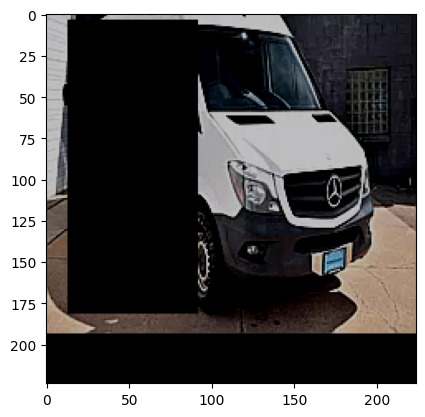

'cargo_van'

In [143]:
idx = 200
img = train_dataset[idx]["image"]
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 0)
img += 0.5
img *= 0.5
plt.imshow(img)
plt.show()
inverse_mappa[train_dataset[idx]["label"]]

Проверка с"битых" изображений

In [127]:
bad_img = []
for i,image in enumerate(test_dataset):
    try: 
        i,image["image"]
    except:
        bad_img.append(i)

# BaseLine Model

In [132]:
# I will use the well-known model
# efficientnet_v2_s with the default weights

model = efficientnet_v2_s(weights='DEFAULT')
num_classes = 9

In [134]:
class CarModel(torch.nn.Module):
    def __init__(self, no_input, no_output):
        super(CarModel, self).__init__()
        
        self.no_output = no_output
        self.no_input = no_input

        self.linear1 = torch.nn.Linear(self.no_input, 256)
        self.activation = torch.nn.Tanh()
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(256, self.no_output)
        

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        
        return nn.functional.softmax(x)
car_model = CarModel(no_input=model.classifier[1].in_features, no_output=num_classes)
epochs = 40

# Train

In [137]:
class Module(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.00001)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch['image'], train_batch['label']
        y_hat = self.model(X)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        loss = criterion(y_hat, y)
        accuracy = Accuracy(task='multiclass',
                                     num_classes=num_classes)#.to(device)
        acc = accuracy(y_hat, y)
        self.log('train_accuracy', acc, on_epoch=True, prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)

        return loss


    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch['image'], val_batch['label']
        y_hat = self.model(X)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        loss = criterion(y_hat, y)
        accuracy = Accuracy(task='multiclass',
                                     num_classes=num_classes)#.to(device)
        acc = accuracy(y_hat, y)
        self.log('test_accuracy', acc, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss, prog_bar=True)

In [139]:
%tensorboard --logdir=tb_logs_cars/

Reusing TensorBoard on port 6006 (pid 22308), started 3:07:10 ago. (Use '!kill 22308' to kill it.)

# Additional Metrics

In [140]:
from lightning.pytorch.loggers import TensorBoardLogger

module = Module(model)
logger = TensorBoardLogger("tb_logs_cars", name='efficientnet_v2_s')

trainer = L.Trainer(max_epochs=epochs, gradient_clip_val=0.4, logger=logger)
trainer.fit(model=module, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 20.5 M
---------------------------------------
20.5 M    Trainable params
0         Non-trainable params
20.5 M    Total params
82.031    Total estimated model params size (MB)


Epoch 0: 100%|███████████████| 954/954 [2:14:16<00:00,  0.12it/s, v_num=4, train_accuracy_step=0.333, train_loss=2.030]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|███████████████| 765/765 [5:40:22<00:00,  0.04it/s, v_num=3, train_accuracy_step=0.565, train_loss=1.890]

Epoch 1: 100%|█| 954/954 [2:34:39<00:00,  0.10it/s, v_num=4, train_accuracy_step=0.500, train_loss=1.900, test_accuracy
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████| 237/237 [08:37<00:00,  0.46it/s]
Epoch 2: 100%|█| 954/954 [2:24:53<00:00,  0.11it/s, v_num=4, train_accuracy_step=0.750, train_loss=1.730, test_accuracy
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████

In [142]:
torch.save(model, 'efficientnet_v2_s_new_data')
